# Import related libraries

In [1]:
import pandas as pd
import string
import spacy
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

# Dateset Preprocessing

In [2]:
#read dataset
data = pd.read_csv('Dataset.csv')
#pre-view of dataset
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017/12/31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017/12/29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017/12/31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017/12/30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017/12/29,1


In [3]:
#count the variable without data
data.isnull().sum()

title      52
text       56
subject    56
date       70
label       0
dtype: int64

In [4]:
#remove null values
data = data.dropna()

#remove duplicate values
data = data.drop_duplicates()

In [5]:
# #randomly chosse 1000 data for test, comment out during official runtime
# data = data.sample(n=1000, random_state=42)

In [6]:
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017/12/31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017/12/29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017/12/31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017/12/30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017/12/29,1


In [7]:
#remove punctuations from text, title, and subject
for col in ['text', 'title', 'subject']:
    data[col] = data[col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [8]:
#self-defined functions to read and store data which maybe download failed
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
def load_variavle(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [9]:
stop_words = load_variavle('stop_words.txt')

In [10]:
#load stop words from nlkt
#if report download fail from nltk, use the file offered above
stop_words = set(stopwords.words('english'))

#remove stop words
for col in ['text', 'title', 'subject']:
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [11]:
#separate words in text, title, and subject
for col in ['text', 'title', 'subject']:
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split()]))

In [12]:
#words stem extraction for text, title, and subject
stemmer = PorterStemmer()
for col in ['text', 'title', 'subject']:
    data[col] = data[col].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

In [13]:
#concatenate 'text', 'title', and 'subject' columns together
data['combined'] = data['title'] + ' ' + data['subject'] + ' ' + data['text']

In [14]:
# calculate the average length of true and fake news
fake_mean_len = data[data['label'] == 0]['combined'].apply(lambda x: len(x)).mean()
real_mean_len = data[data['label'] == 1]['combined'].apply(lambda x: len(x)).mean()

print("average length of fake news：", fake_mean_len)
print("average length of true news：", real_mean_len)

average length of fake news： 1683.8501534265258
average length of true news： 1627.9312149356465


In [15]:
data = data.reset_index(drop=True)

#speatre feature column and label column
X = data['combined']
y = data['label']

In [16]:
#initialize
vectorizer = TfidfVectorizer(stop_words='english')
#vetorize
X = vectorizer.fit_transform(X)

In [17]:
#Divide the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters Choosing

In [18]:
#Hyperparameters tuning

#Scramble training set
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

#Choose first 1000 samples to process tuning
X_train_subset = X_train_shuffled[:1000]
y_train_subset = y_train_shuffled[:1000]

#define parameters space
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10]}

#svm define
svm_clf = SVC()

#create GridSearchCV object
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)

#search hyper parameters in train set
grid_search.fit(X_train_subset, y_train_subset)

#get the best parameters and cross-validation score
print("Best parameters:", grid_search.best_params_)
print("Cross-validation score:", grid_search.best_score_)

Best parameters: {'C': 10, 'gamma': 0.1}
Cross-validation score: 0.97


# Model Fitting

In [19]:
#define svm with best parameters
svm_clf = SVC(C=10, gamma=0.1)

#fit model in train set
svm_clf.fit(X_train, y_train)

#predict
y_pred = svm_clf.predict(X_test)

#get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9968662562954672


# Model Evaluation

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(cm)

#precision
precision = precision_score(y_test, y_pred)
print(precision)

#recall
recall = recall_score(y_test, y_pred)
print(recall)

#F-measure
f1 = f1_score(y_test, y_pred)
print(f1)

[[4646   12]
 [  16 4261]]
0.9971916686168968
0.9962590600888473
0.9967251461988305


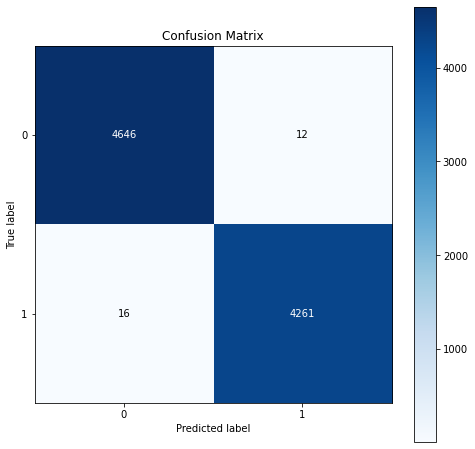

In [21]:
#draw confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Blues')

#add labels
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.xticks(rotation=0)
plt.title("Confusion Matrix")

#add numbers
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

#add color bar
plt.colorbar(im)
plt.grid(False)
plt.savefig('confusion_matrix.png',dpi=800)
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4658
           1       1.00      1.00      1.00      4277

    accuracy                           1.00      8935
   macro avg       1.00      1.00      1.00      8935
weighted avg       1.00      1.00      1.00      8935



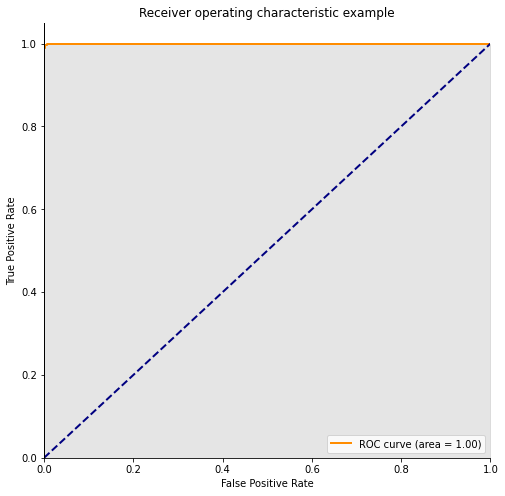

AUC: 0.9999483994441194


In [23]:
from sklearn.metrics import roc_curve, auc

#get prediction probabilit
y_score = svm_clf.decision_function(X_test)

#calculation
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#draw ROC
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.fill_between(fpr, tpr, color='gray', alpha=0.2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

#add axis
ax.axhline(0, color='black', lw=1)
ax.axvline(0, color='black', lw=1)


#set background and countours
ax.set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('ROC.png', dpi=800)
plt.show()

#output AUC
print("AUC:", roc_auc)


# Other Operations

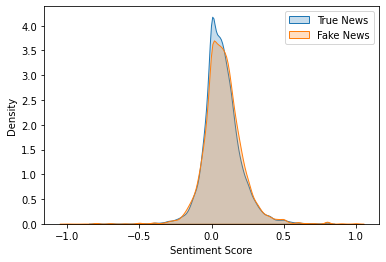

In [24]:
import pandas as pd
from textblob import TextBlob
import seaborn as sns

#define sentiment analysis function
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

#analyze
data['sentiment'] = data['combined'].apply(get_sentiment)

#divide true and false
true_news = data[data['label'] == 1]
fake_news = data[data['label'] == 0]

#draw sentiment lines
sns.kdeplot(true_news['sentiment'], shade=True, label='True News')
sns.kdeplot(fake_news['sentiment'], shade=True, label='Fake News')

#label settings
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.savefig('sentiment.png', dpi=800)

plt.show()


In [25]:
#add some stop words
stop_words.add('said')
stop_words.add('say')
stop_words.add('one')
stop_words.add('n')
stop_words.add('u')

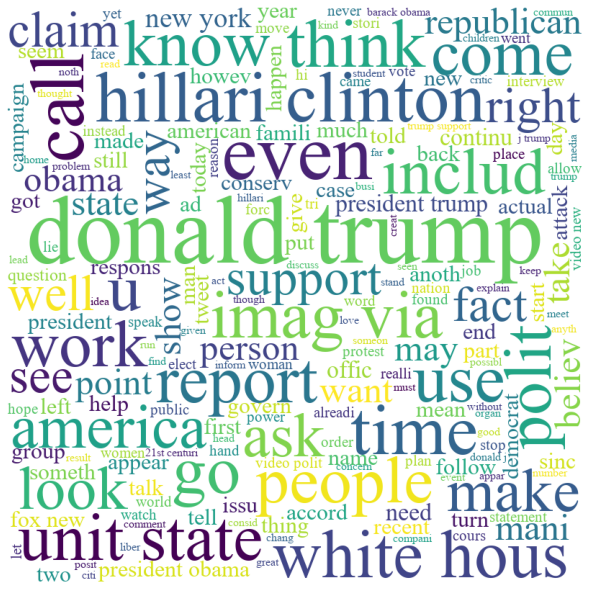

In [26]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#remove stop words

data['combined'] = data['combined'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
#read fake news data

fake_data = data[data['label'] == 0]['combined'].values
#make into string type
fake_text = ' '.join(fake_data)

#correct some typos
fake_text_correct = ''
for i in fake_text.split():
    if i == 'peopl':
        fake_text_correct += ' ' + 'people'
    elif i == 'presid':
        fake_text_correct += ' ' + 'president'
    elif i == 'thi':
         fake_text_correct += ' '
    elif i == 'offici':
         fake_text_correct += 'official'
    elif i == 'polic':
         fake_text_correct += 'police'
    elif i == 'white hous':
         fake_text_correct += 'white house'   
    elif i == 'countri':
         fake_text_correct += 'countries'   
    else:
        fake_text_correct += ' ' + i

fake_wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  stopwords = STOPWORDS, 
                  min_font_size = 10,font_path =  "times.ttf").generate(fake_text_correct)
#Plot the WordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(fake_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.savefig('cloud.png', dpi=800)
plt.show()